## Imports and frameworks

In [1]:
import os
from tqdm import tqdm
import torch
import gc
import numpy as np
from torch.utils.data import DataLoader
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityd, EnsureTyped, CenterSpatialCropd
)
from monai.utils import set_determinism
from monai.networks.nets import ResNet
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

## Dataloading and transforms

In [2]:
set_determinism(seed=42)  # Set random seed for deterministic training

# Define data directories
ad_dir, cn_dir = os.path.join("data/AD"), os.path.join("data/CN")

# Prepare data for training and validation
def get_file_list(data_path, label):
    return [{"image": os.path.join(data_path, f), "label": label} for f in os.listdir(data_path) if f.endswith(".nii")]

data_list = get_file_list(ad_dir, 1) + get_file_list(cn_dir, 0)
np.random.shuffle(data_list)

# Split into training and validation sets (20/80 split)
n_val = int(len(data_list) * 0.2)  # Get the number of validation samples (20%)
train_data, val_data = data_list[:-n_val], data_list[-n_val:]  # Slice the list

roi_size = (50, 96, 96) # Because using the RAS coordinate system depth will be first (D, H, W) (50, 96, 96) | default -> (96, 96, 50)

# Define basic transforms (no augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]), # Just load the image data (.nii files also contain meta data)
    EnsureChannelFirstd(keys=["image"]), # Channel-first format (C, D, H, W)
    Orientationd(keys=["image"], axcodes="RAS"), # Normalize orientation to RAS (Right, Anterior, Superior)
    CenterSpatialCropd(keys=["image"], roi_size=roi_size),  # Crop the middle 50 slices (using normalized axes)
    #Resized(keys=["image"], spatial_size=(96, 96, 96)),  # Resize after cropping
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"), #  Rescale the image to isotropic spacing
    ScaleIntensityd(keys=["image"]), # Scale intensity values
    EnsureTyped(keys=["image"]), # Ensure the image is a tensor
])

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    CenterSpatialCropd(keys=["image"], roi_size=roi_size),  # Crop the middle 50 slices
    #Resized(keys=["image"], spatial_size=(96, 96, 96)),  # Resize after cropping
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    ScaleIntensityd(keys=["image"]),
    EnsureTyped(keys=["image"]),
])

# Create datasets using CacheDataset for caching
train_ds = CacheDataset(data=train_data, transform=train_transforms)
val_ds = CacheDataset(data=val_data, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|███████████████████████████████████████████████████████████████| 196/196 [00:32<00:00,  5.97it/s]


## Define ResNet-50

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet
model = ResNet(
    block="bottleneck",
    layers = (3, 4, 6, 3), # ResNet-18 -> (2, 2, 2, 2) ResNet-50 -> (3, 4, 6, 3)
    block_inplanes=(64, 128, 256, 512),
    spatial_dims=3,
    n_input_channels=1,
    num_classes=2
).to(device)
device

device(type='cuda')

## Loss function and optimizer

In [4]:
# Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
from torchinfo import summary
summary(model, input_size=(1, 1, 50, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv3d: 1-1                            [1, 64, 50, 96, 96]       21,952
├─BatchNorm3d: 1-2                       [1, 64, 50, 96, 96]       128
├─ReLU: 1-3                              [1, 64, 50, 96, 96]       --
├─MaxPool3d: 1-4                         [1, 64, 25, 48, 48]       --
├─Sequential: 1-5                        [1, 256, 25, 48, 48]      --
│    └─ResNetBottleneck: 2-1             [1, 256, 25, 48, 48]      --
│    │    └─Conv3d: 3-1                  [1, 64, 25, 48, 48]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 25, 48, 48]       128
│    │    └─ReLU: 3-3                    [1, 64, 25, 48, 48]       --
│    │    └─Conv3d: 3-4                  [1, 64, 25, 48, 48]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 25, 48, 48]       128
│    │    └─ReLU: 3-6                    [1, 64, 25, 48, 48]       --


# Training loop and validation evaluation loop

In [6]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

epochs = 20
best_metric, best_metric_epoch = -1, -1

# Lists to store metrics for plotting
train_losses, val_losses = [], []
val_accuracies, val_precisions, val_recalls, val_f1_scores = [], [], [], []

print(f"Training on {len(train_data)} samples, validating on {len(val_data)} samples.")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Training phase
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch") as pbar_train:
        for batch in pbar_train:
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            # Delete references to tensors that are no longer needed
            del inputs, labels, outputs
            gc.collect() # Force garbage collection to free memory
            torch.cuda.empty_cache() # Free any unused GPU memory

            # Update tqdm progress bar description
            pbar_train.set_postfix(loss=loss.item(), epoch_loss=epoch_loss / len(train_loader))
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    total_samples = 0
    all_val_labels, all_val_preds = [], []
    with torch.inference_mode():
        with tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}", unit="batch") as pbar_val:
            for val_batch in pbar_val:
                val_inputs, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
                val_outputs = model(val_inputs)
                
                val_loss += loss_function(val_outputs, val_labels).item()
                val_correct += (val_outputs.argmax(dim=1) == val_labels).sum().item()
                total_samples += val_labels.size(0)
                
                all_val_labels.extend(val_labels.cpu().numpy())
                all_val_preds.extend(val_outputs.softmax(dim=1).cpu().numpy()[:, 1])  # Probabilities

                # Update tqdm progress bar description
                pbar_val.set_postfix(val_loss=val_loss / (total_samples + 1), accuracy=val_correct / total_samples)
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = val_correct / total_samples
    val_accuracies.append(accuracy)
    print(f"Validation loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, F1 score
    precision = precision_score(all_val_labels, np.round(all_val_preds))
    recall = recall_score(all_val_labels, np.round(all_val_preds))
    f1 = f1_score(all_val_labels, np.round(all_val_preds))
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    if accuracy > best_metric:
        best_metric = accuracy
        best_metric_epoch = epoch + 1

print(f"Training complete. Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

gc.collect()
torch.cuda.empty_cache()

Training on 788 samples, validating on 196 samples.
Epoch 1/20


Training Epoch 1/20: 100%|██████████████████████████| 197/197 [02:07<00:00,  1.54batch/s, epoch_loss=0.732, loss=0.615]


Training loss: 0.7325


Validating Epoch 1/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.34batch/s, accuracy=0.403, val_loss=0.196]


Validation loss: 0.7877, Accuracy: 0.4031
Precision: 0.4031, Recall: 1.0000, F1 Score: 0.5745
Epoch 2/20


Training Epoch 2/20: 100%|██████████████████████████| 197/197 [02:45<00:00,  1.19batch/s, epoch_loss=0.708, loss=0.668]


Training loss: 0.7084


Validating Epoch 2/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.408, val_loss=0.197]


Validation loss: 0.7936, Accuracy: 0.4082
Precision: 0.4051, Recall: 1.0000, F1 Score: 0.5766
Epoch 3/20


Training Epoch 3/20: 100%|██████████████████████████| 197/197 [02:18<00:00,  1.42batch/s, epoch_loss=0.703, loss=0.674]


Training loss: 0.7034


Validating Epoch 3/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.633, val_loss=0.163]


Validation loss: 0.6561, Accuracy: 0.6327
Precision: 0.5593, Recall: 0.4177, F1 Score: 0.4783
Epoch 4/20


Training Epoch 4/20: 100%|██████████████████████████| 197/197 [02:33<00:00,  1.29batch/s, epoch_loss=0.631, loss=0.728]


Training loss: 0.6313


Validating Epoch 4/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.597, val_loss=0.222]
C:\Users\Josh\anaconda3\envs\PyTorch-Course\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation loss: 0.8936, Accuracy: 0.5969
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 5/20


Training Epoch 5/20: 100%|██████████████████████████| 197/197 [02:50<00:00,  1.15batch/s, epoch_loss=0.543, loss=0.445]


Training loss: 0.5426


Validating Epoch 5/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.821, val_loss=0.117]


Validation loss: 0.4714, Accuracy: 0.8214
Precision: 0.8333, Recall: 0.6962, F1 Score: 0.7586
Epoch 6/20


Training Epoch 6/20: 100%|██████████████████████████| 197/197 [02:04<00:00,  1.58batch/s, epoch_loss=0.485, loss=0.137]


Training loss: 0.4853


Validating Epoch 6/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.714, val_loss=0.142]


Validation loss: 0.5694, Accuracy: 0.7143
Precision: 0.6095, Recall: 0.8101, F1 Score: 0.6957
Epoch 7/20


Training Epoch 7/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.446, loss=0.315]


Training loss: 0.4461


Validating Epoch 7/20: 100%|█████████████████████████| 49/49 [00:36<00:00,  1.34batch/s, accuracy=0.76, val_loss=0.148]


Validation loss: 0.5946, Accuracy: 0.7602
Precision: 0.9444, Recall: 0.4304, F1 Score: 0.5913
Epoch 8/20


Training Epoch 8/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.311, loss=0.813]


Training loss: 0.3111


Validating Epoch 8/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.776, val_loss=0.163]


Validation loss: 0.6555, Accuracy: 0.7755
Precision: 0.9268, Recall: 0.4810, F1 Score: 0.6333
Epoch 9/20


Training Epoch 9/20: 100%|███████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.253, loss=0.18]


Training loss: 0.2533


Validating Epoch 9/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.796, val_loss=0.0994]


Validation loss: 0.3998, Accuracy: 0.7959
Precision: 0.6893, Recall: 0.8987, F1 Score: 0.7802
Epoch 10/20


Training Epoch 10/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.293, loss=0.0973]


Training loss: 0.2935


Validating Epoch 10/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.878, val_loss=0.072]


Validation loss: 0.2894, Accuracy: 0.8776
Precision: 0.9661, Recall: 0.7215, F1 Score: 0.8261
Epoch 11/20


Training Epoch 11/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.199, loss=0.107]


Training loss: 0.1989


Validating Epoch 11/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.847, val_loss=0.121]


Validation loss: 0.4860, Accuracy: 0.8469
Precision: 0.9298, Recall: 0.6709, F1 Score: 0.7794
Epoch 12/20


Training Epoch 12/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.225, loss=0.372]


Training loss: 0.2255


Validating Epoch 12/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.903, val_loss=0.0705]


Validation loss: 0.2835, Accuracy: 0.9031
Precision: 0.9054, Recall: 0.8481, F1 Score: 0.8758
Epoch 13/20


Training Epoch 13/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.145, loss=0.0712]


Training loss: 0.1453


Validating Epoch 13/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.883, val_loss=0.0673]


Validation loss: 0.2706, Accuracy: 0.8827
Precision: 0.8889, Recall: 0.8101, F1 Score: 0.8477
Epoch 14/20


Training Epoch 14/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.117, loss=0.0107]


Training loss: 0.1165


Validating Epoch 14/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.893, val_loss=0.0617]


Validation loss: 0.2482, Accuracy: 0.8929
Precision: 0.8452, Recall: 0.8987, F1 Score: 0.8712
Epoch 15/20


Training Epoch 15/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.098, loss=0.674]


Training loss: 0.0980


Validating Epoch 15/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.32batch/s, accuracy=0.648, val_loss=0.179]


Validation loss: 0.7213, Accuracy: 0.6480
Precision: 0.5385, Recall: 0.8861, F1 Score: 0.6699
Epoch 16/20


Training Epoch 16/20: 100%|███████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.175, loss=0.00641]


Training loss: 0.1750


Validating Epoch 16/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.903, val_loss=0.0632]


Validation loss: 0.2539, Accuracy: 0.9031
Precision: 0.9167, Recall: 0.8354, F1 Score: 0.8742
Epoch 17/20


Training Epoch 17/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.0504, loss=0.239]


Training loss: 0.0504


Validating Epoch 17/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.34batch/s, accuracy=0.923, val_loss=0.0613]


Validation loss: 0.2463, Accuracy: 0.9235
Precision: 0.9103, Recall: 0.8987, F1 Score: 0.9045
Epoch 18/20


Training Epoch 18/20: 100%|███████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.0966, loss=0.0165]


Training loss: 0.0966


Validating Epoch 18/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.913, val_loss=0.0743]


Validation loss: 0.2989, Accuracy: 0.9133
Precision: 0.9559, Recall: 0.8228, F1 Score: 0.8844
Epoch 19/20


Training Epoch 19/20: 100%|███████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.097, loss=0.00354]


Training loss: 0.0970


Validating Epoch 19/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.923, val_loss=0.0716]


Validation loss: 0.2880, Accuracy: 0.9235
Precision: 1.0000, Recall: 0.8101, F1 Score: 0.8951
Epoch 20/20


Training Epoch 20/20: 100%|█████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.0172, loss=0.000472]


Training loss: 0.0172


Validating Epoch 20/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.34batch/s, accuracy=0.918, val_loss=0.0614]

Validation loss: 0.2469, Accuracy: 0.9184
Precision: 0.9091, Recall: 0.8861, F1 Score: 0.8974
Training complete. Best accuracy: 0.9235 at epoch 17
[INFO] Total training time: 3338.474 seconds


## Plot Metrics

### Plot Training and Validation Losses

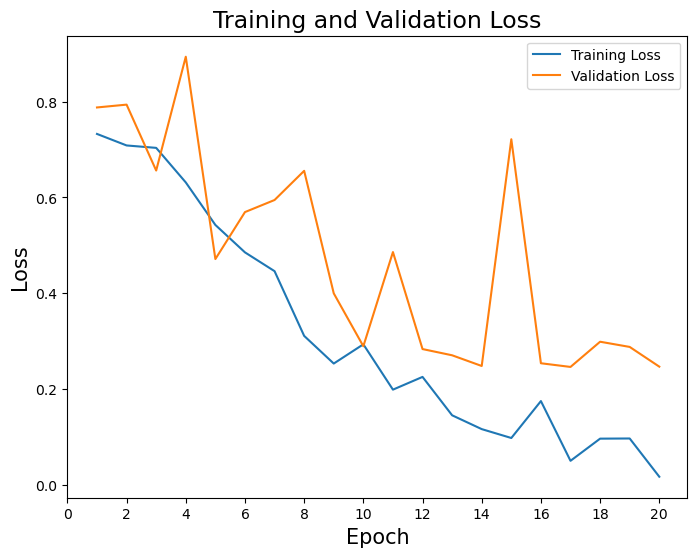

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.title("Training and Validation Loss", fontsize=17)
plt.legend()
plt.xticks(range(0, epochs + 1, 2))
plt.savefig("figures/train_and_val_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot Validation Accuracy

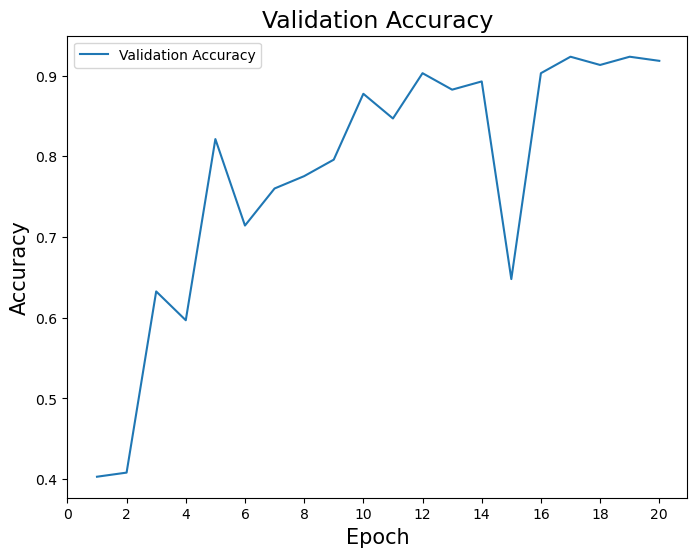

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Validation Accuracy", fontsize=17)
plt.legend()
plt.xticks(range(0, epochs + 1, 2))
plt.savefig("figures/val_accuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot Precision, Recall, and F1 Score

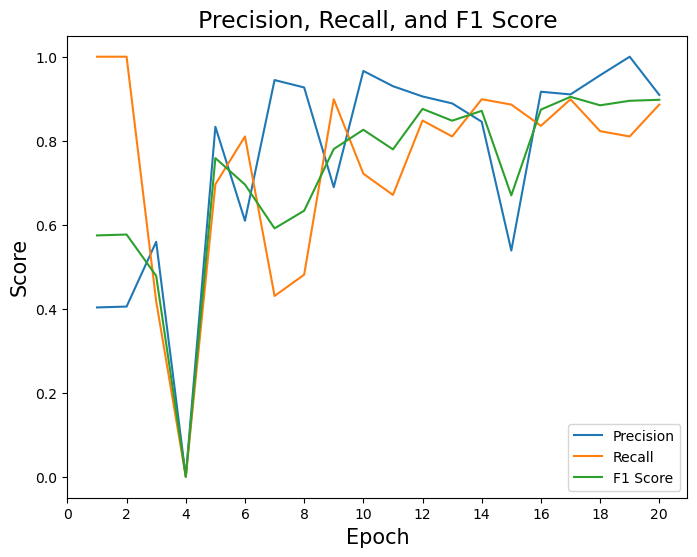

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), val_precisions, label="Precision")
plt.plot(range(1, epochs + 1), val_recalls, label="Recall")
plt.plot(range(1, epochs + 1), val_f1_scores, label="F1 Score")
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Score", fontsize=15)
plt.title("Precision, Recall, and F1 Score", fontsize=17)
plt.legend()
plt.xticks(range(0, epochs + 1, 2))
plt.savefig("figures/precision_recall_f1_scores.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot the ROC Curve

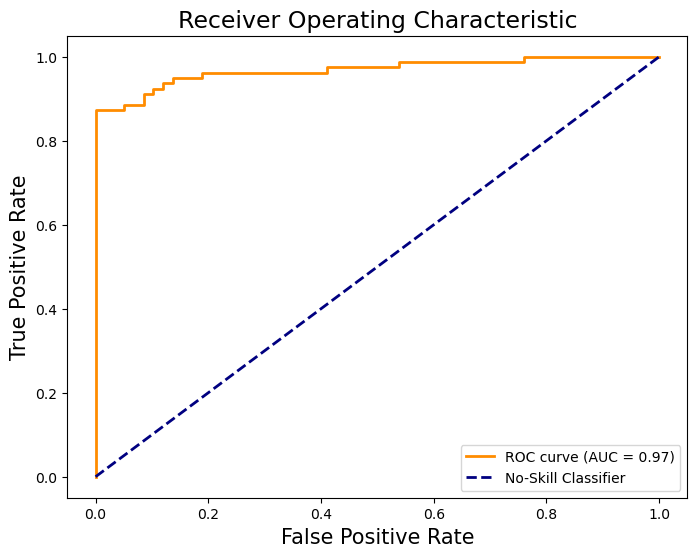

In [68]:
fpr, tpr, _ = roc_curve(all_val_labels, all_val_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, label="No-Skill Classifier", linestyle="--")
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver Operating Characteristic", fontsize=17)
plt.legend(loc="lower right")
plt.savefig("figures/roc_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Plot Confusion Matrix

<Figure size 800x600 with 0 Axes>

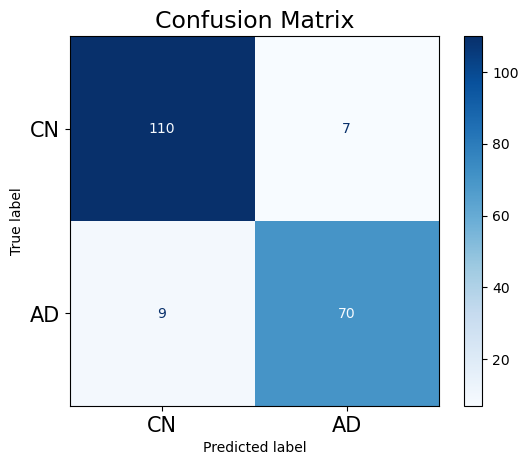

In [69]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_val_labels, np.round(all_val_preds))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CN", "AD"])
disp.plot(cmap="Blues")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Confusion Matrix", fontsize=17)
plt.savefig("figures/confusion_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()